In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
from dynamics.rigid_body_dynamics.Aircraft2D import Aircraft2DPointMass
import pathlib as plb
from dynamics.AeroModelling.SimpleAircraft2D import SimpleAircraft2D
from dynamics.AeroModelling.airfoilPerformanceModels import liftCoefficientFlapAlfa,momentCoefficientFlapAlfa,dragCoefficientFlapAlfa

from dynamics.AeroModelling.courtinSurrogates import *
from dynamics.AeroModelling.propulsorModels import *

In [2]:
# generate aircraft model, assign parameter for wing, tail
Throttle = dyn.delta_T*20/100 * (9.81*dyn.mass) # give thrust as a fraction of the weight
b = 3.05
c = 0.38
bt = 1.27
ct = 0.25

# blowing / other params
E = 0.3 # flap chord fraction
Adisk = .065
h = 0.1
c = 0.38
rho = 1.225
# aircraft model, add geometric params
AeroModel = SimpleAircraft2D()
# mass
# inertia
# wing, tail span, chord, areas



In [2]:
# set up tail aero model
AeroModel.LiftCoeffTailFunc = lambda x,y,z: 2*np.pi*x
AeroModel.DragCoeffTailFunc = lambda x,y,z: 2*np.pi*x # need to double check what this is func of
AeroModel.MomentCoeffTailFunc = lambda x,y,z: 0

In [3]:
# set up wing aeromodel
AeroModel.LiftCoeffFunc = liftCoeff
AeroModel.DragCoeffFunc = dragCoeff
AeroModel.MomentCoeffFunc = pitchingCoeff

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9915440e+03 0.00e+00 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [4]:
# set up the optimization problem and parameters

opti = asb.Opti()

# variable time
N = 100
# time = np.linspace(0,50,N)

time = np.linspace(
    0,
    40,
    N
)
dyn = Aircraft2DPointMass(
    mass = 9.54, # kg
    Iyy = 2.5, # kg-m^2
    x_e = opti.variable(init_guess=1*np.linspace(1,100,N),upper_bound=1e4,lower_bound=-1),
    z_e = opti.variable(init_guess=1*np.linspace(1,100,N),upper_bound=1e4,lower_bound=-1e4),
    w_b = opti.variable(init_guess=0*np.linspace(1,30,N),upper_bound=30,lower_bound=-30),
    u_b = opti.variable(init_guess=1*np.linspace(1,30,N),upper_bound=50,lower_bound=0),
    pitch = opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=360*2,lower_bound=-180),
    # delta_f=  opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=45,lower_bound=0),
    delta_f = 0 * np.ones(N,),
    delta_ht = opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=30,lower_bound=-30),
    delta_T = opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=1,lower_bound=0),
)

dyn.WindModel.setParameters("gaussian1D",**{"center":300,"std":10,"MaxGustVelocity":0,"axis":"z"})



In [5]:
# use aero model to constraint the dynamics problem

dyn.setDynamics(aeromodel)
dyn.add_force(1,2,3,'wind')
dyn.add_moment(1,'wind')

In [7]:
# general constraints for physical motion / other physical limits


# general forward motion and boundary limits
opti.subject_to([
    dyn.u > 0,
    dyn.z_e >= 0,
    dyn.x_e >=0,
])



# physical limits
opti.subject_to([
    dyn.alpha >=-12,
    dyn.alpha <= 15,
])

# rate limits
throttle_rate = np.diff(dyn.delta_T) / np.diff(time)
flap_rate = np.diff(dyn.delta_f) / np.diff(time)
tail_rate = np.diff(dyn.delta_ht) / np.diff(time)
pitch_rate = np.diff(dyn.pitch,2) / np.diff(time,1)

opti.subject_to([
    dyn.delta_T >= 0,
    dyn.delta_T <= 1,
    throttle_rate >=-.2,
    throttle_rate <= .2,
    tail_rate >= -5,
    tail_rate <= 5,
    pitch_rate >=-30,
    pitch_rate <= 30,
])






[MX(fabs(opti3_lam_g_20)),
 MX(fabs(opti3_lam_g_21)),
 MX(fabs(opti3_lam_g_22)),
 MX(fabs(opti3_lam_g_23)),
 MX(fabs(opti3_lam_g_24)),
 MX(fabs(opti3_lam_g_25)),
 MX(fabs(opti3_lam_g_26)),
 MX(fabs(opti3_lam_g_27))]

In [8]:

# start constraints
opti.subject_to([
    dyn.x_e[0] == 0,  # starting position arbitrarily 0
    dyn.z_e[0] == 500,  # starting altitude of 2km (~180 ft)
    pitch_rate[0] == 0,  # no pitching rate ye
])

# end constraints
opti.subject_to([
    dyn.x_e[-1] <=5e4,  # arbitrary x limit
])

# cost function work


# push all constraints to the problem


In [ ]:
# set cost function
opti.minimize(np.sum(dyn.glide_slope**2)/10**2 + np.sum(np.diff(dyn.delta_T)**2))

In [9]:
# constrain derivatives and solve
dyn.constrain_derivatives(opti,time,method="cubic")
sol = opti.solve(max_iter=1000,behavior_on_failure="return_last")
dyn = sol(dyn)
time = sol(time)
    


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9660
Number of nonzeros in inequality constraint Jacobian.:     3489
Number of nonzeros in Lagrangian Hessian.............:     1799

Total number of variables............................:      700
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      498
Total number of inequality constraints...............:     2695
        inequality constraints with only lower bounds:     1497
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1198

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.99e+02 1.11e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

CasADi - 2025-06-16 16:00:19 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 2896, col 0).") [.../casadi/core/oracle_function.cpp:393]


  17  1.2179203e+03 3.85e+02 2.09e+05   2.3 3.87e+02   3.0 1.24e-02 3.88e-03h  1
  18  1.2193261e+03 3.84e+02 2.09e+05   2.3 3.85e+02   2.5 1.03e-04 1.78e-03h  1
  19  1.2237089e+03 3.82e+02 1.97e+05   2.3 3.84e+02   2.9 1.75e-04 6.57e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2237483e+03 3.82e+02 6.09e+05   1.6 3.82e+02   3.3 2.17e-02 8.17e-05h  1
  21  1.2244476e+03 3.81e+02 9.66e+05   1.6 3.82e+02   2.9 1.68e-02 1.07e-03h  1
  22  1.2520604e+03 3.77e+02 8.94e+05   1.6 3.81e+02   2.4 2.57e-03 1.25e-02h  1
  23  1.2529847e+03 3.76e+02 8.81e+05   1.6 4.06e+02   2.8 2.06e-05 8.32e-04h  1
  24  1.2532645e+03 3.76e+02 1.39e+06   1.6 4.56e+02   3.2 1.39e-02 3.82e-04h  1
  25  1.2565215e+03 3.75e+02 1.39e+06   1.6 5.09e+02   2.8 2.66e-03 2.68e-03h  1
  26  1.2635208e+03 3.74e+02 1.46e+06   1.6 3.75e+02   2.3 8.55e-03 3.19e-03h  1
  27  1.2808744e+03 3.69e+02 1.40e+06   1.6 3.74e+02   2.7 1.19e-02 1.43e-02h  1
  28  1.2931030e+03 3.69e+02

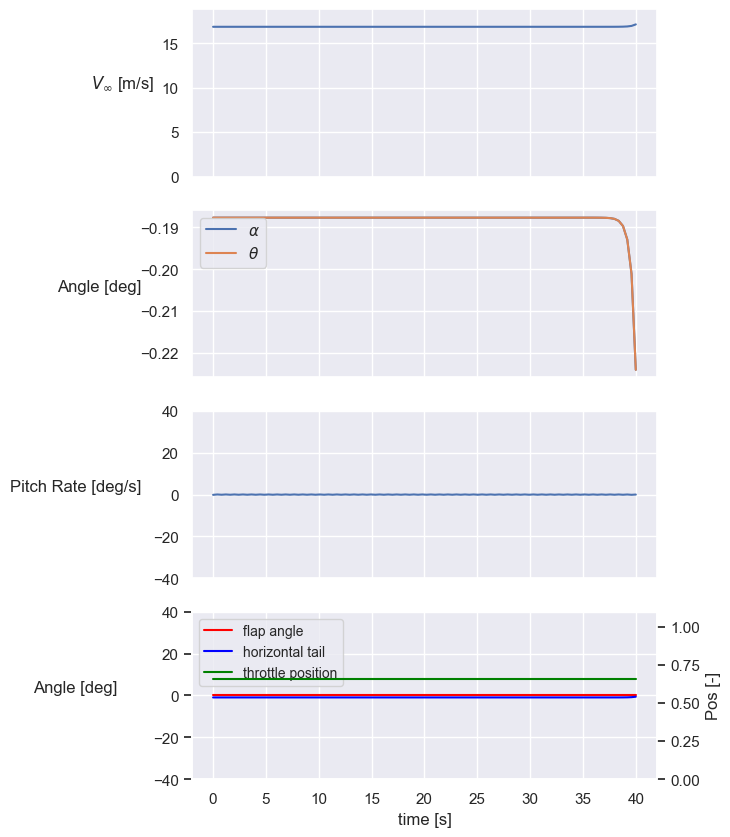

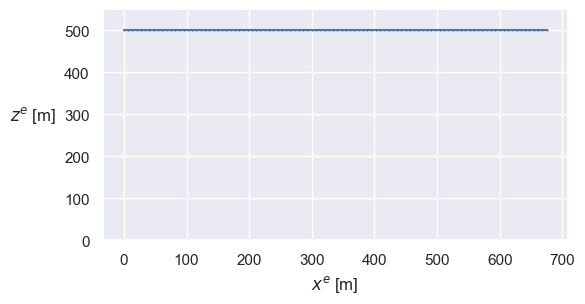

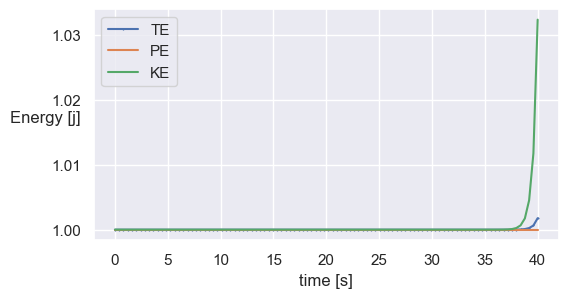

In [10]:
from dynamics.rigid_body_dynamics.visualization import visualizeRun2D
fig_dict = visualizeRun2D(time,dyn)

In [46]:
run_name = "cruise_15ms_gust"
import pathlib as plb
cwd = plb.Path.cwd()
dyn_savepath = plb.Path(f"{cwd}/temp/dyn_{run_name}") 
dyn.save(dyn_savepath,verbose=True)

Saving <dynamics.rigid_body_dynamics.Aircraft2D.Aircraft2DPointMass object at 0x11ce80f20> to:
	/Users/trevorlong/Documents/MIT/PhD/aircraft-dynamics/studies/temp/dyn_cruise_15ms_gust.asb...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/trevorlong/Documents/MIT/PhD/aircraft-dynamics/studies/temp/dyn_cruise_15ms_gust.asb'